# Load from Files 

In [42]:
 # -------------------------
    # Import Packages
 # -------------------------

import altair as alt
import streamlit as st
import pandas as pd
import glob
import pickle
import random
import numpy as np
import gzip
import matplotlib.pyplot as plt



 # -------------------------
    # Load from Files
 # -------------------------

# Create dictionaries for models + vectorizers and lists for validation DataFrames
models = {}
vectorizers = {}
X_vals = []
Y_vals = []

model_paths = glob.glob('..\\Data\\finalized_model*')
vectorizer_paths = glob.glob('..\\Data\\finalized_vectorizer*')
X_val_paths = glob.glob('..\\Data\\X_val*')
y_val_paths = glob.glob('..\\Data\\y_val*')

# Load models
for path in model_paths:
    nm = path.split('_')[-1].split('.')[0]
    models[nm] = pickle.load(open(path, 'rb'))

# Load Vectorizers
for path in vectorizer_paths:
    nm = path.split('_')[-1].split('.')[0]
    vectorizers[nm] = pickle.load(open(path, 'rb'))

# Load X_Val Paths + Put in DataFrame
for path in X_val_paths:
    nm = path.split('_')[-1].split('.')[0]
    df = pd.read_csv(path, index_col = 0)
    df['Section'] = nm
    X_vals.append(df)

# Load Y_Val Paths + Put in DataFrame
for path in y_val_paths:
    nm = path.split('_')[-1].split('.')[0]
    df = pd.read_csv(path, index_col = 0)
    df['Section'] = nm
    Y_vals.append(df)

# Combine X_val + Y_val DataFrames
X_vals_df = pd.concat(X_vals)
X_vals_df.columns = ['TEXT', 'Section_drop']
X_vals_df = X_vals_df.reset_index(drop=True)
Y_vals_df = pd.concat(Y_vals)
Y_vals_df = Y_vals_df.reset_index(drop=True)
val_df = pd.concat([X_vals_df, Y_vals_df], axis=1)
val_df.drop('Section_drop', axis=1, inplace=True)

,TEXT,CPT_CD,Section,ICD9_CODE
0,discharge date ...,99232.0,Evaluation and management,NaN
1,discharge date ...,99233.0,Evaluation and management,NaN
2,discharge date sex ...,99232.0,Evaluation and management,NaN
3,discharge date ...,99291.0,Evaluation and management,NaN
4,discharge date ...,99232.0,Evaluation and management,NaN
...,...,...,...,...
723,admission date discharge date date o...,36620.0,Surgery,NaN
724,discharge date ...,36620.0,Surgery,NaN
725,discharge date ...,31624.0,Surgery,NaN
726,discharge date ...,36556.0,Surgery,NaN


# Make Predictions

In [181]:
def make_predictions(df, section='icd', other_text=[]):
    
    #Subset the DataFrame
    df = df[df['Section'] == section].reset_index()
    
    # Choose a random row
    random.seed(30)
    row = round(random.random() * (len(df) - 1))

    # Make list for storing tuples of the code, prediction confidence, and type (CPT or ICD)
    ls = []

    # Load text data
    if len(other_text) > 0:
        input_text_clean = other_text
    else:
        input_text_clean = df.loc[row, 'TEXT']
    
    # Load Vectorizers + transform data
    for key, vectorizer in vectorizers.items():
        vectorizer_txt = vectorizer.transform([input_text_clean])

        # Load corresponding model and make prediction
        prediction = models[key].predict(vectorizer_txt)[0]
#         confidence_prob = str(round(max(models[key].predict_proba(vectorizer_txt)[0]) * 100\
#                                  ,2)
#                              ) + '%'
        confidence_prob = round(max(models[key].predict_proba(vectorizer_txt)[0]),2)
        ls.append((confidence_prob, prediction, key))

    # Create DataFrame
    predict_df = pd.DataFrame(ls)
    predict_df.columns = ['conf_prob', 'code', 'section']
    
    # Print the original billing code
    print('Original Billing Code:', df.loc[row, 'ICD9_CODE'])

    # ICD 9 CODE
    if np.isnan(df.loc[row, 'CPT_CD']):
        predict_df['ICD9_CODE'] = df.loc[row, 'ICD9_CODE']
        
    # CPT CODE
    else:
        predict_df['CPT_CD'] = df.loc[row, 'CPT_CD']

    # Add Additional Columns
    predict_df['OG section'] = df.loc[row, 'Section']
    type_map = {'Evaluation and management':'CPT ', 'icd':'ICD9 ', 'Medicine':'CPT ', 'other':'CPT ','Radiology':'CPT ','Surgery':'CPT '}
    predict_df['TYPE'] = predict_df['section'].map(type_map)
    predict_df['code_updated'] = predict_df['TYPE'] + predict_df['code']
    
    display(predict_df)
    display(input_text_clean)
    
    predict_df = predict_df.merge(diagnosis_dsc, on = 'ICD9_CODE')
    
    print(predict_df)
    
    return predict_df, input_text_clean

predict_df, input_text_clean = make_predictions(val_df, 'icd')

Original Billing Code: 41401


,conf_prob,code,section,ICD9_CODE,OG section,TYPE,code_updated
0,0.40,99231,Evaluation and management,41401,icd,CPT,CPT 99231
1,0.89,41401,icd,41401,icd,ICD9,ICD9 41401
2,0.62,94002,Medicine,41401,icd,CPT,CPT 94002
3,0.41,99141,other,41401,icd,CPT,CPT 99141
4,0.45,76942,Radiology,41401,icd,CPT,CPT 76942
5,0.40,31645,Surgery,41401,icd,CPT,CPT 31645


'          discharge date                sex   m    this is a    year old gentleman with significant risk factors for coronary artery disease including increased blood pressure  high cholesterol  positive family history and tobacco abuse who presents with shoulder and jaw discomfort   his discomfort occurs with exertion but also occurs without any exertion at all   the patient had an episode of this pain last week   an exercise tolerance test showed   depression inferiorly and a defect on the myocardial perfusion scan    left carotid stenosis with no history of transient ischemic attacks  peptic ulcer disease  high blood pressure  high cholesterol  status post pilonidal cyst removal    family history of coronary artery disease    pulse     blood pressure         general   in no apparent distress   skin is warm and well perfused   pulmonary   scattered rhonchi   no wheezes or rales   cardiovascular   regular   normal s  and s    no murmurs  rubs or gallops   abdomen   soft  non tender a

   conf_prob   code                    section ICD9_CODE OG section   TYPE  \
0       0.40  99231  Evaluation and management     41401        icd   CPT    
1       0.89  41401                        icd     41401        icd  ICD9    
2       0.62  94002                   Medicine     41401        icd   CPT    
3       0.41  99141                      other     41401        icd   CPT    
4       0.45  76942                  Radiology     41401        icd   CPT    
5       0.40  31645                    Surgery     41401        icd   CPT    

  code_updated  ROW_ID               SHORT_TITLE  \
0    CPT 99231    4374  Crnry athrscl natve vssl   
1   ICD9 41401    4374  Crnry athrscl natve vssl   
2    CPT 94002    4374  Crnry athrscl natve vssl   
3    CPT 99141    4374  Crnry athrscl natve vssl   
4    CPT 76942    4374  Crnry athrscl natve vssl   
5    CPT 31645    4374  Crnry athrscl natve vssl   

                                          LONG_TITLE  
0  Coronary atherosclerosis of na

# QA Check - Make Sure Predict Proba is Predicting the Highest Probability

In [101]:
# Choose a random row
random.seed(2)
row = round(random.random() * (len(val_df) - 1))

# Load text data
input_text_clean = val_df.loc[row, 'TEXT']

# Load Vectorizers + transform data
vectorizer_txt = vectorizers['icd'].transform([input_text_clean])

# Load corresponding model and make prediction
prediction = models['icd'].predict(vectorizer_txt)[0]
confidence_prob_ls = models['icd'].predict_proba(vectorizer_txt)[0]

# Find the max prediction and it's index
max_ = max(confidence_prob_ls)
index = list(confidence_prob_ls).index(max_)

# Find the corresponding class
class_ = models['icd'].classes_[index]

# Print class and prediction
print(class_, prediction)

41071 41071


# Load ICD + CPT Descriptions

In [131]:
# Load ICD Descriptions
with gzip.open('..\\Data\\MIMIC Files\\D_ICD_DIAGNOSES.csv.gz', mode='r') as file:
    diagnosis_dsc = pd.read_csv(file)

# Load CPT Descriptions --> TO DO 

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


In [165]:
predict_df.merge(diagnosis_dsc, on = 'ICD9_CODE')

,conf_prob,code,section,ICD9_CODE,OG section,TYPE,ROW_ID,SHORT_TITLE,LONG_TITLE
0,0.40,CPT 99231,Evaluation and management,41401,icd,CPT,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
1,0.89,ICD9 41401,icd,41401,icd,ICD9,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
2,0.62,CPT 94002,Medicine,41401,icd,CPT,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
3,0.41,CPT 99141,other,41401,icd,CPT,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
4,0.45,CPT 76942,Radiology,41401,icd,CPT,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
5,0.40,CPT 31645,Surgery,41401,icd,CPT,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...


# Plot Predictions

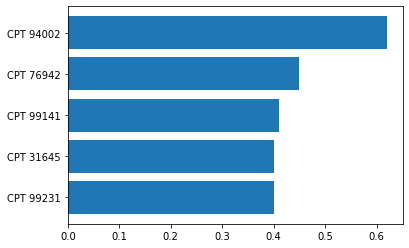

In [147]:
df = predict_df[predict_df.section != 'icd']
df = df.sort_values('conf_prob')
plt.barh(df.code, df.conf_prob)
plt.show()


In [161]:
def icd_pred(predict_df):
    pred_icd = predict_df[predict_df.section == 'icd']['ICD9_CODE'].values[0]
    pred_icd_prob = predict_df[predict_df.section == 'icd']['conf_prob'].values[0]

    return pred_icd, pred_icd_prob

pred_icd, pred_icd_prob = icd_pred(predict_df)

type(pred_icd_prob)
# + ': ' + str(round((pred_icd_prob * 100))) + '%'

numpy.float64

In [173]:
val_df[val_df.CPT_CD.isnull()]

,TEXT,CPT_CD,Section,ICD9_CODE
170,discharge date ...,NaN,icd,4241
171,discharge date ...,NaN,icd,0389
172,discharge date sex ...,NaN,icd,V3001
173,discharge date sex ...,NaN,icd,41401
174,discharge date ...,NaN,icd,41401
...,...,...,...,...
311,discharge date ...,NaN,icd,41071
312,discharge date ...,NaN,icd,41401
313,discharge date ...,NaN,icd,0389
314,discharge date ...,NaN,icd,4241


In [178]:
features = pd.read_csv('C:\\Users\\amartins\\Documents\\Personal\\School\\1 - SPRING 2021 SEMESTER\\Final Project & Capstone\\Improving-Healthcare-Using-NLP---COMP-5360-Final\\Data\\features_df.csv', index_col=0)
features[(features.Section == 'icd') & (features.Class == '41401')]

,Prob,Features,Class,Direction,Section
0,0.055654,valve replacement,41401,Bottom,icd
1,0.074971,replacement,41401,Bottom,icd
2,0.078060,aortic stenosis,41401,Bottom,icd
3,0.102757,avr,41401,Bottom,icd
4,0.120198,aortic,41401,Bottom,icd
...,...,...,...,...,...
95,0.687800,bruits,41401,Top,icd
96,0.685736,mg day,41401,Top,icd
97,0.685100,times three,41401,Top,icd
98,0.684351,procedure,41401,Top,icd


In [207]:
features_df = features
df = predict_df.merge(features_df, left_on = ['section', 'code'], right_on = ['Section', 'Class'])\
          .sort_values(['Class', 'Prob'], ascending=False)\

df_top = df[df.Direction == 'Top'].loc[:, ['Section', 'Features', 'Prob']]  

for i in set(df_top.Section):
    print(i,'\n')
    display(pd.DataFrame(df_top[df_top.Section == i].head(25).reset_index(drop=True)))

icd 



,Section,Features,Prob
0,icd,coronary artery,0.948268
1,icd,artery,0.944465
2,icd,coronary,0.936850
3,icd,stress,0.932369
4,icd,stress test,0.914978
5,icd,artery bypass,0.900608
6,icd,artery disease,0.893721
7,icd,bypass,0.885747
8,icd,angina,0.880363
9,icd,test,0.873981


Medicine 



,Section,Features,Prob
0,Medicine,mgmt st,1.000000
1,Medicine,st day,1.000000
2,Medicine,day invasive,0.999999
3,Medicine,st,0.999908
4,Medicine,mgmt,0.977088
5,Medicine,vent mgmt,0.976832
6,Medicine,invasive,0.966166
7,Medicine,vent,0.961363
8,Medicine,lasix,0.829548
9,Medicine,job vent,0.809207


Evaluation and management 



,Section,Features,Prob
0,Evaluation and management,renal,0.813434
1,Evaluation and management,renal insufficiency,0.746810
2,Evaluation and management,bruit,0.744194
3,Evaluation and management,hemodialysis,0.742820
4,Evaluation and management,catheterization,0.736997
5,Evaluation and management,stress,0.729359
6,Evaluation and management,main,0.724374
7,Evaluation and management,mi,0.722428
8,Evaluation and management,hospital,0.708615
9,Evaluation and management,vessel,0.705475


Surgery 



,Section,Features,Prob
0,Surgery,bronchoscopy,0.906654
1,Surgery,secretions,0.855477
2,Surgery,tube,0.809398
3,Surgery,tracheostomy,0.782025
4,Surgery,trach,0.773838
5,Surgery,chest tube,0.752098
6,Surgery,hemoptysis,0.736992
7,Surgery,bronch,0.730108
8,Surgery,stent,0.724480
9,Surgery,lung,0.720077


Radiology 



,Section,Features,Prob
0,Radiology,thoracentesis,0.709011
1,Radiology,qd,0.637954
2,Radiology,job,0.618301
3,Radiology,cell,0.611039
4,Radiology,status post,0.610754
5,Radiology,pleural,0.605966
6,Radiology,mg qd,0.595737
7,Radiology,pleural effusion,0.594658
8,Radiology,effusion,0.594474
9,Radiology,fluid,0.589360


other 



,Section,Features,Prob
0,other,examination,0.615320
1,other,transplant,0.615081
2,other,failure,0.595701
3,other,blood cell,0.590109
4,other,status post,0.589374
5,other,job,0.584177
6,other,patient also,0.583273
7,other,cell count,0.580471
8,other,respiratory rate,0.575274
9,other,white blood,0.575112


In [200]:
?pd.DataFrame.reset_index